### Практическое задание. Урок 4.

#### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.75,
    random_state=5
)

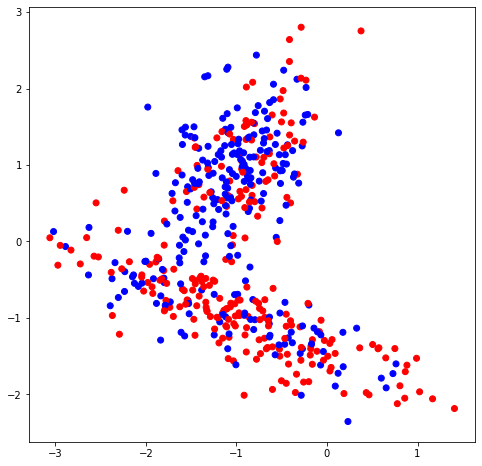

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
            c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):

    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth=5, max_leaf=62, depth=1):

    max_leaf_new = max_leaf - 2*2**(depth-1)

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Точка останова по глубине дерева
    if max_depth == 0:
        return Leaf(data, labels)

    # Точка останова по максимальному количеству листьев
    # (срабатывает раньше, если не хватает листьев для формирования полного дерева)
    if max_leaf <= 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth=max_depth-1, max_leaf=max_leaf_new, depth=depth+1)
    false_branch = build_tree(false_data, false_labels, max_depth=max_depth-1, max_leaf=max_leaf_new, depth=depth+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=10, max_leaf=6)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

print_tree(my_tree)

Индекс 1
Порог -0.46624201061399206
--> True:
  Индекс 0
  Порог -1.79696585158631
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Индекс 0
  Порог -0.9820958539320116
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)

In [17]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

65.71428571428571

In [20]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

62.66666666666667

Text(0.5, 1.0, 'Test accuracy=62.67')

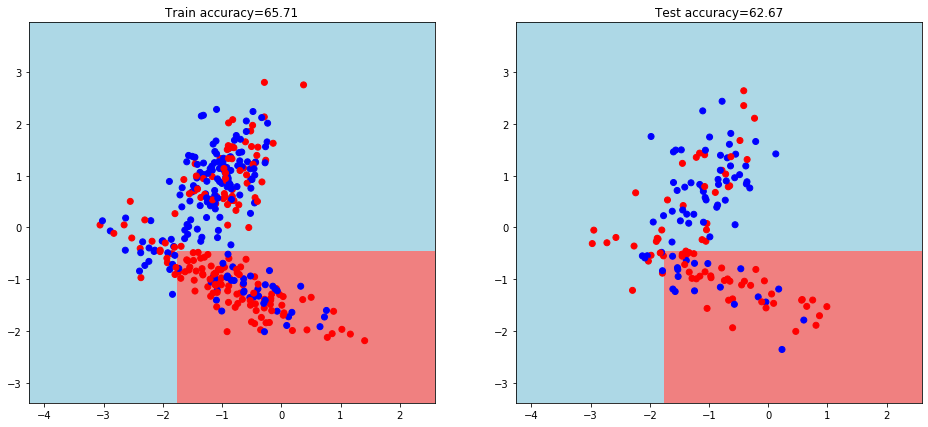

In [21]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [22]:
np.mean(test_labels)

0.4866666666666667

#### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [23]:
import math

In [24]:
# Расчет критерия Энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    # энтропия
    entropy = 0.
    for label in classes:
        p = classes[label] / len(labels)
        entropy -= p*math.log2(p)

    return entropy

In [25]:
_gini = gini(train_labels)
_gini

0.4999346938775511

In [26]:
_entropy = entropy(train_labels)
_entropy

0.9999057811299177

In [27]:
# Расчет качества

def quality_new(left_labels, right_labels, current_criterion, criterion_type='gini'):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    if criterion_type == 'entropy':
        return current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    else:
        return current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [28]:
# Нахождение наилучшего разбиения

def find_best_split_new(data, labels, criterion_type='gini'):

    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    if criterion_type == 'entropy':
        current_criterion = entropy(labels)
    else:
        current_criterion = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality_new(true_labels, false_labels, current_criterion, criterion_type)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [29]:
# Построение дерева с помощью рекурсивной функции

def build_tree_new(data, labels, criterion_type='gini', max_depth=5, max_leaf=62, depth=1):

    max_leaf_new = max_leaf - 2*2**(depth-1)

    quality, t, index = find_best_split_new(data, labels, criterion_type)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Точка останова по глубине дерева
    if max_depth == 0:
        return Leaf(data, labels)

    # Точка останова по максимальному количеству листьев
    # (срабатывает раньше, если не хватает листьев для формирования полного дерева)
    if max_leaf <= 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_new(true_data, true_labels, criterion_type, max_depth=max_depth-1, max_leaf=max_leaf_new, depth=depth+1)
    false_branch = build_tree_new(false_data, false_labels, criterion_type, max_depth=max_depth-1, max_leaf=max_leaf_new, depth=depth+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [30]:
my_tree_gini = build_tree_new(train_data, train_labels, 'gini', max_depth=10, max_leaf=50)
my_tree_entropy = build_tree_new(train_data, train_labels, 'entropy', max_depth=10, max_leaf=50)

In [31]:
print_tree(my_tree_gini)

Индекс 1
Порог -0.46624201061399206
--> True:
  Индекс 0
  Порог -1.79696585158631
  --> True:
    Индекс 0
    Порог -1.9226384124885603
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0
    Порог -1.1834902220493384
    --> True:
      Индекс 0
      Порог -1.6959366052924192
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 1
      Порог -1.2659561512192585
      --> True:
        Индекс 0
        Порог 0.7624451741809175
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.645018457805447
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 1
--> False:
  Индекс 0
  Порог -0.9820958539320116
  --> True:
    Индекс 0
    Порог -1.6445609784573159
    --> True:
      Индекс 0
      Порог -2.3038245881450266
      --> True:
        Индекс 0
        Порог -2.6270558616603794
        --> True:
       

In [32]:
print_tree(my_tree_entropy)

Индекс 1
Порог -0.46624201061399206
--> True:
  Индекс 0
  Порог -1.79696585158631
  --> True:
    Индекс 1
    Порог -0.7126883788993976
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -1.1834902220493384
    --> True:
      Индекс 0
      Порог -1.6959366052924192
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 0
      Порог 0.7624451741809175
      --> True:
        Индекс 1
        Порог -1.2659561512192585
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 0
--> False:
  Индекс 0
  Порог -0.9820958539320116
  --> True:
    Индекс 0
    Порог -1.6445609784573159
    --> True:
      Индекс 0
      Порог -2.3038245881450266
      --> True:
        Индекс 0
        Порог -2.6270558616603794
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Индекс 1
        Порог -0.26601

In [33]:
# Получим ответы для обучающей выборки
train_answers_gini = predict(train_data, my_tree_gini)
train_answers_entropy = predict(train_data, my_tree_entropy)

In [34]:
# И получим ответы для тестовой выборки
answers_gini = predict(test_data, my_tree_gini)
answers_entropy = predict(test_data, my_tree_entropy)

In [35]:
# Точность на обучающей выборке
train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
train_accuracy_entropy = accuracy_metric(train_labels, train_answers_entropy)
train_accuracy_gini, train_accuracy_entropy

(73.42857142857143, 71.14285714285714)

In [36]:
# Точность на тестовой выборке
test_accuracy_gini = accuracy_metric(test_labels, answers_gini)
test_accuracy_entropy = accuracy_metric(test_labels, answers_entropy)
test_accuracy_gini, test_accuracy_entropy

(60.66666666666667, 62.0)

Text(0.5, 1.0, 'Test accuracy gini=60.67 \nTest accuracy entropy=62.00')

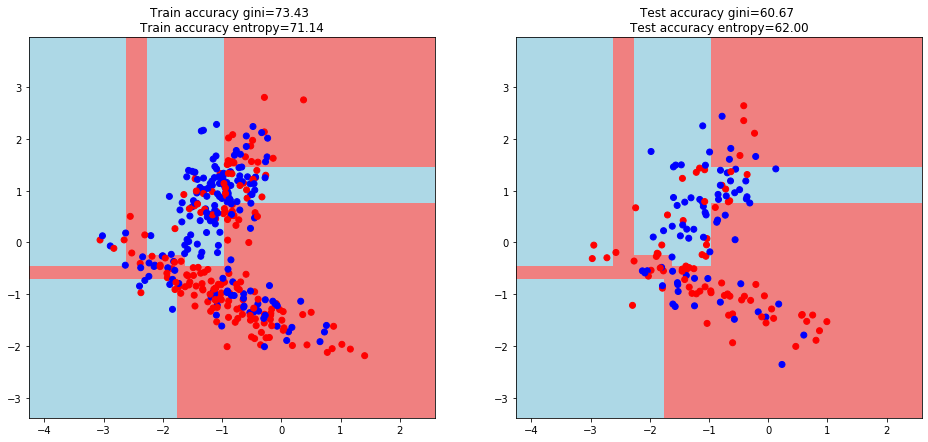

In [37]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions_gini = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_gini)).reshape(xx.shape)
mesh_predictions_entropy = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_entropy)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions_gini, cmap = light_colors)
plt.pcolormesh(xx, yy, mesh_predictions_entropy, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy gini={train_accuracy_gini:.2f} \n'
          f'Train accuracy entropy={train_accuracy_entropy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions_gini, cmap = light_colors)
plt.pcolormesh(xx, yy, mesh_predictions_entropy, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy gini={test_accuracy_gini:.2f} \n'
          f'Test accuracy entropy={test_accuracy_entropy:.2f}')

В данном примере качество классификации с использованием обоих критереев очень схожи.